<a href="https://colab.research.google.com/github/Sujay8070/Image-Denoising/blob/main/Img_Restore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2  #
import numpy as np
from scipy.fftpack import fft, dct, idct
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Add, Conv2D, Activation, MaxPooling2D ,AveragePooling2D, BatchNormalization, Lambda, Conv2DTranspose, Dropout, concatenate
from math import log10, sqrt
from PIL import Image, ImageOps
from glob import glob   #
import os
import time
from tensorflow.keras import callbacks, regularizers
from keras.callbacks import TensorBoard
from keras.preprocessing.image import img_to_array, array_to_img
from sklearn.model_selection import train_test_split
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

  
start = time.time()



In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
###Connect to drive
from  google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!ls drive
Xtrain_path = '/content/drive/My Drive/dataset/AugmentedData/'
Ytrain_path = '/content/drive/My Drive/dataset/all_JPG/'
model_path ='/content/drive/My Drive/dataset/Model.png'
image_path ='/content/drive/My Drive/dataset/Cat.jpg'
np.random.seed = 1
img_size = (128,128) 
print('folder paths defined...') 


MyDrive
folder paths defined...


In [ ]:

def flip_image(path , photo, dir):
    originalImage = cv2.imread(path+photo)
    #originalImage = cv2.resize(img, (240,240))
    flipVertical = cv2.flip(originalImage, 0)
    flipHorizontal = cv2.flip(originalImage, 1)
    flipBoth = cv2.flip(originalImage, -1)

    os.chdir(dir)
    cv2.imwrite(photo.split(".") [0]+'_a.jpg', originalImage)
    cv2.imwrite(photo.split(".") [0]+'_b.jpg', flipVertical)
    cv2.imwrite(photo.split(".") [0]+'_c.jpg', flipHorizontal)
    cv2.imwrite(photo.split(".") [0]+'_d.jpg', flipBoth)




def create_blurr_images(path,directory,photo,jpg_folder):
    img = cv2.imread(path + photo)
    #im = cv2.resize(img, (480, 480))

    size = 17
    ###############generating the horizontal kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur [int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur/size
    ############ applying the kernel to the input image
    output1 = cv2.filter2D(img, -1, kernel_motion_blur)

    # generating the vertical kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur [:, int((size-1)/2)] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur/size
    # applying the kernel to the input image
    output2 = cv2.filter2D(img, -1, kernel_motion_blur)
    # cv2.waitKey(0)


    os.chdir(directory)
    cv2.imwrite(photo.split(".")[0] +'_1.jpg', output1)
    cv2.imwrite(photo.split(".")[0] +'_2.jpg', output2)

    os.chdir(jpg_folder)
    cv2.imwrite(photo.split(".") [0]+'_1.jpg', img)
    cv2.imwrite(photo.split(".") [0]+'_2.jpg', img)



###########--------define paths
source_folder = '/content/drive/My Drive/dataset/original/'
buffer_folder = '/content/drive/My Drive/dataset/flipped/'
dest_folder = Xtrain_path
jpg_folder = Ytrain_path


for photo in os.listdir(source_folder):
    #print(photo.split(".")[0])
    flip_image(source_folder, photo, buffer_folder)
print('All Images flipped...')
for photo in os.listdir(buffer_folder):
    #print(photo.split(".")[0])
    create_blurr_images(buffer_folder, dest_folder, photo, jpg_folder)
print('All Images augmented...')


All Images flipped...
All Images augmented...


In [ ]:
def check_train_data(path1, path2):
    list_A = []
    list_B = []
    for photo in os.listdir(path1):
        photo_name = photo.split(".") [0]
        list_A.append(photo_name)

    for photo in os.listdir(path2):
        photo_name = photo.split(".") [0]
        #print(photo_name)
        list_B.append(photo_name)
    #print (len(list_A), len(list_B), len(list_A)==len(list_B))

    for i in range(len(list_A)):
        if list_A[i]!= list_B[i]:
            print (list_A[i],list_B[i] )
    if list_A == list_B:
            print("All filenames match!")

check_train_data(path1 = Xtrain_path, path2 = Ytrain_path)

All filenames match!


In [ ]:
def create_datasets():
    X_train_list = []
    for filename in os.listdir(Xtrain_path):                ##D:/SUJAY/Img_restore /dataset/motion_blurred/*.jpg
        #image = Image.open(Xtrain_path + filename)
        #im = ImageOps.grayscale(image)
        #img1 = im.resize(img_size)
        original = cv2.imread(Xtrain_path + filename, cv2.IMREAD_GRAYSCALE)
        img1 = cv2.resize(original, img_size)
        dct_img = dct(img1, type=2, n=None, axis=- 1, norm=None, overwrite_x=True)
        X_train_list.append(img_to_array(img1))
    noisy_train = np.array(X_train_list)    ##+ np.random.normal(0, 0.001, size=X_train_list.shape)
    print('blurr image-array shape:\n', noisy_train.shape)  

    Y_train_list = []
    for filename1 in os.listdir(Ytrain_path):
        #image1 = Image.open(Ytrain_path + filename1)
        #im1 = ImageOps.grayscale(image1)
        #img2 = im1.resize(img_size)
        original1 = cv2.imread(Ytrain_path + filename1, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.resize(original1, img_size)
        dct_img1 = dct(img2, type=2, n=None, axis=- 1, norm=None, overwrite_x=True)
        Y_train_list.append(img_to_array(img2))
    sharp_train = np.array(Y_train_list)         
    print('Sharp image-array shape:\n', sharp_train.shape)


    return noisy_train, sharp_train

noisy_train, sharp_train = create_datasets() 



blurr image-array shape:
 (6192, 128, 128, 1)
Sharp image-array shape:
 (6192, 128, 128, 1)


In [ ]:
Input_shape = noisy_train [1].shape
#noisy_train = ((noisy_train)/255 - 127)/128           ###scaling for DCT values
#sharp_train = ((sharp_train)/255 -127)/128            ###scaling for DCT values
noisy_train = (noisy_train)/255
sharp_train = (sharp_train)/255
print(np.min(sharp_train[10,:,:,0]) , np.max(sharp_train[10,:,:,0]))
print(np.min(noisy_train[10,:,:,0]), np.max(noisy_train[10,:,:,0])) 

0.003921569 1.0
0.011764706 0.99607843


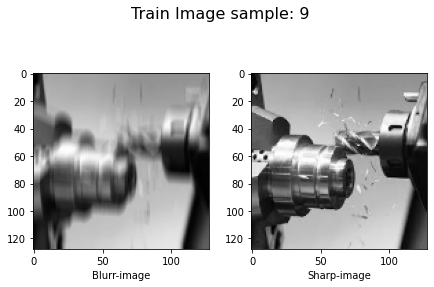

In [ ]:
##display Images----------------------------------------------------------------
def display(i):
    fig, axs = plt.subplots(1,2, constrained_layout=True)
    axs[0].imshow(tf.keras.preprocessing.image.array_to_img(noisy_train[i]), cmap='gray')
    axs[0].set_xlabel('Blurr-image')
    fig.suptitle('Train Image sample: ' + str(i), fontsize=16)
    axs[1].imshow(tf.keras.preprocessing.image.array_to_img(sharp_train[i]),cmap='gray')
    axs[1].set_xlabel('Sharp-image')
    plt.show()


display(9)                      #call display
#print (noisy_train[1,:,:,0].shape, sharp_train[2].shape, sharp_train[3,:].shape)
#print (noisy_train[10,1,1,0],sharp_train[10,1,1,0])

def disp_idct(i):
    Idct_img = idct((noisy_train[i,:,:,0]*65025.0), type=2, n=None, axis=- 1, norm=None, overwrite_x=False)
    plt.title('Blurr-image (iDCT value): Sample 10')
    plt.imshow(Idct_img, cmap='gray')
    plt.show()

    Idct_img1 = idct(sharp_train[i,:,:,0]*65025.0, type=2, n=None, axis=- 1, norm=None, overwrite_x=False)
    plt.title('Sharp-image (iDCT value): sample 10')    
    plt.imshow(Idct_img1, cmap='gray')
    plt.show()

#disp_idct(25)                      #call display


old model, only conv-deconv. 

In [ ]:
"""
def U_conv_block(X,f):
    C = Conv2D(f, (3, 3), (1, 1), padding='same', kernel_initializer='he_normal')(X)
    # C = Dropout(0.1)(C1)
    C = BatchNormalization( axis=-1, momentum=0.99)(C)
    C = Activation('relu')(C)
    C = Conv2D(f, (3, 3), (1, 1), padding='same', kernel_initializer='he_normal')(C)
    C = BatchNormalization(axis=-1, momentum=0.99 )(C)
    C = Activation('relu')(C)
    #P = MaxPooling2D((2, 2))(C)
    return C


def U_deconv_block(X, C ,f):
    U = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(X)
    U = concatenate([U, C])
    C1 = Conv2D(f, (3, 3), (1, 1), padding='same', kernel_initializer='he_normal')(U)
    C1 = BatchNormalization( axis=-1, momentum=0.99)(C1)
    C1 = Activation('relu')(C1)
    # C1 = Dropout(0.2)(C1)
    C1 = Conv2D(f, (3, 3), (1, 1), padding='same', kernel_initializer='he_normal')(C1)
    C1 = BatchNormalization( axis=-1, momentum=0.99)(C1)
    C1 = Activation('relu')(C1)
    return C1,U
    
##define--the----model------------------------------------------------------------
inputs = Input((img_size[0],img_size[1],1))
X = inputs


C1 = Conv2D(16, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal' )(X)
C1 = BatchNormalization(axis=-1, momentum=0.99)(C1)
C1 = Conv2D(16, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(C1)
#C1 = U_conv_block(C1, f= 16)        ## complex encoding
P1 = MaxPooling2D((2,2))(C1)


C2 = Conv2D(32, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(P1)
C2 = BatchNormalization(axis=-1, momentum=0.99)(C2)
C2 = Conv2D(32, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(C2)
#C2 = U_conv_block(C2, f= 32)        ## complex encoding
P2 = MaxPooling2D((2,2))(C2)

C3 = Conv2D(64, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(P2)
C3 = BatchNormalization(axis=-1, momentum=0.99)(C3)
C3 = Conv2D(64, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(C3)
#C3 = U_conv_block(C3, f= 64)        ## complex encoding
P3 = MaxPooling2D((2,2))(C3)

C4 = Conv2D(128, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(P3)
C4 = BatchNormalization(axis=-1, momentum=0.99)(C4)
C4 = Conv2D(128, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(C4)
#C4 = U_conv_block(C4, f= 128)        ## complex encoding
P4 = MaxPooling2D((2,2))(C4)

C5 = Conv2D(256, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(P4)
C5 = BatchNormalization(axis=-1, momentum=0.99)(C5)
C5 = Conv2D(256, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(C5)
#C5 = U_conv_block(C5, f= 256)        ## complex encoding


###Up-sampling---deconv: with prev results--------------------------
U6 = Conv2DTranspose(128, (2,2), strides= (2,2), padding= 'same')(C5)
U6 = concatenate([U6,C4])
C6 = Conv2D(128, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(U6)
C6 = BatchNormalization(axis=-1, momentum=0.99)(C6)
C6 = Conv2D(128, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(C6)

U7 = Conv2DTranspose(64, (2,2), strides= (2,2), padding= 'same')(C6)
U7 = concatenate([U7,C3])
C7 = Conv2D(64, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(U7)
C7 = BatchNormalization(axis=-1, momentum=0.99)(C7)
C7 = Conv2D(64, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(C7)

U8 = Conv2DTranspose(32, (2, 2), strides= (2, 2), padding= 'same')(C7)
U8 = concatenate([U8,C2])
C8 = Conv2D(32, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(U8)
C8 = BatchNormalization(axis=-1, momentum=0.99)(C8)
C8 = Conv2D(32, (3, 3), (1, 1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(C8)

U9 = Conv2DTranspose(16, (2, 2), strides= (2, 2), padding= 'same')(C8)
U9 = concatenate([U9,C1])
C9 = Conv2D(16, (3,3), (1,1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(U9)
C9 = BatchNormalization(axis=-1, momentum=0.99)(C9)
C9 = Conv2D(16, (3, 3), (1, 1), padding = 'same', activation= 'relu', kernel_initializer= 'he_normal')(C9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(C9)


###Train_model------------------------------------------------------------------

model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name='U-Net_Img_denoising')
model.summary()
plot_model( model, to_file="model_final.png")
"""

Model design 2: for flexibility  in increasing layers


In [ ]:
def U_conv_block(X,f):
    C = Conv2D(f, (3, 3), (1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer= 'L2', bias_regularizer='L2')(X)
    # C = Dropout(0.1)(C1)
    C = BatchNormalization( axis=-1, momentum=0.99)(C)
    C = Activation('relu')(C)
    C = Conv2D(f, (3, 3), (1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer= 'L2', bias_regularizer='L2' )(C)
    C = BatchNormalization(axis=-1, momentum=0.99 )(C)
    C = Activation('relu')(C)
    P = MaxPooling2D((2, 2))(C)
    return C, P

def U_deconv_block(X, C ,f):
    U = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(X)
    U = concatenate([U, C])
    C1 = Conv2D(f, (3, 3), (1, 1), padding='same', kernel_initializer='he_normal',  kernel_regularizer= 'L2', bias_regularizer='L2')(U)
    C1 = BatchNormalization( axis=-1, momentum=0.99)(C1)
    C1 = Activation('relu')(C1)
    # C1 = Dropout(0.2)(C1)
    C1 = Conv2D(f, (3, 3), (1, 1), padding='same', kernel_initializer='he_normal',  kernel_regularizer= 'L2', bias_regularizer='L2')(C1)
    C1 = BatchNormalization( axis=-1, momentum=0.99)(C1)
    C1 = Activation('relu')(C1)
    return C1,U
	
	
inputs = Input((128,128,1))
X = inputs

C1, P1 = U_conv_block(X, f= 64)
C2, P2 = U_conv_block(P1, f= 128)
C3, P3 = U_conv_block(P2, f= 256)
C4, P4 = U_conv_block(P3, f= 512)


C5 = Conv2D(1024, (3, 3), (1, 1), padding='same', activation='relu', kernel_initializer='he_normal',  kernel_regularizer= 'L2', bias_regularizer='L2')(P4)
#C5 = Dropout(0.3)(C5)
C5 = Conv2D(1024, (3, 3), (1, 1), padding='same', activation='relu', kernel_initializer='he_normal',  kernel_regularizer= 'L2', bias_regularizer='L2')(C5)

###Up-sampling---deconv: with prev results---------------------------------------
C6, U6 = U_deconv_block(C5, C4, f= 521)
C7, U7 = U_deconv_block(C6, C3, f= 256)
C8, U8 = U_deconv_block(C7, C2, f= 128)
C9, U9 = U_deconv_block(C8, C1, f= 64)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(C9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name='U-Net_Img_denoising')
model.summary()
plot_model( model, to_file="model_final.png")

In [ ]:
 ###Train_model------------------------------------------------------------------

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate= 0.0001,
    decay_steps=5000,
    decay_rate=0.9,
    staircase = True)
#Opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.99, nesterov=False, name="SGD")
Opt = tf.keras.optimizers.Adam(learning_rate= lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, name="Adam")

model.compile(optimizer= Opt , loss='mean_squared_error' )    ##loss='mean_squared_error'


##callbacks------Model Checkpoint----------------------------------------------
checkpointer = tf.keras.callbacks.ModelCheckpoint('Img_denoising.h5', verbose=1, save_best_only=True)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs'), checkpointer]

x_train, x_test, y_train, y_test = train_test_split(noisy_train, sharp_train, test_size = 0.08, random_state = 0)
results = model.fit(x_train, y_train , epochs=100, batch_size = 32, shuffle=True, verbose=1, validation_split=0.2, callbacks=callbacks)
#print(results)

preds = model.evaluate(x_test, y_test)
print ("Loss = " + str(preds))
#print ("Test Accuracy = " + str(preds[1]))


end = time.time()

dict_keys(['loss', 'val_loss'])


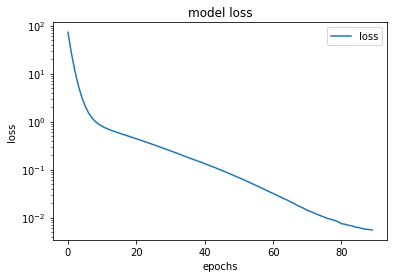

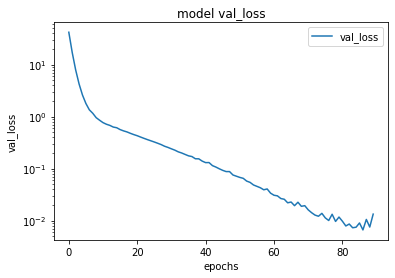

In [ ]:
print(results.history.keys())

def plot_graphs(y):
  plt.plot(results.history[y])
  plt.title('model '+ str(y))
  plt.xlabel('epochs')
  plt.ylabel(y)
  plt.yscale('log')
  #plt.ylim(0.0001,0.001)
  plt.legend([y], loc='upper right')
  plt.show()

plot_graphs(y = 'loss')
plot_graphs(y = 'val_loss')

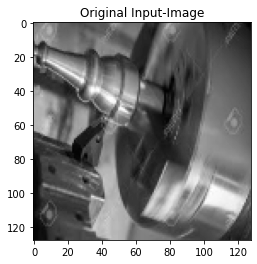

Input-Test image shape: (1, 128, 128, 1)


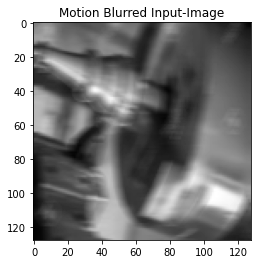

Restored-Test image shape: (128, 128)


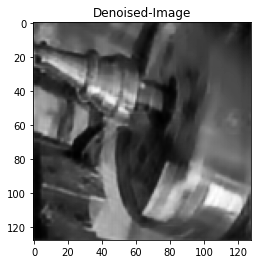

Loss = 0.013125866651535034
Executed in : 4427.103490591049 sec
Image Restored in : 0.754979133605957 sec


In [ ]:
######## Sanity check on random images from test data------------------------

original = cv2.imread('/content/drive/My Drive/dataset/all_JPG/download_d_1.jpg', cv2.IMREAD_GRAYSCALE)
original = cv2.resize(original, img_size)
plt.title('Original Input-Image')
plt.imshow(original, cmap = 'gray')             ##showing blurred img
plt.show()

sample = cv2.imread('/content/drive/My Drive/dataset/AugmentedData/download_d_1.jpg', cv2.IMREAD_GRAYSCALE)
#sample = cv2.imread('/content/drive/My Drive/dataset/Images/images (4)_c_1.jpg', cv2.IMREAD_GRAYSCALE)
sample_img = cv2.resize(sample, img_size)

size = 7
# generating the vertical kernel
kernel_motion_blur = np.zeros((size, size))
kernel_motion_blur [int((size-1)/2),:] = np.ones(size)
kernel_motion_blur = kernel_motion_blur/size
# applying the kernel to the input image
img = cv2.filter2D(original, -1, kernel_motion_blur)


#dct_img = dct(sample_img, type=2, n=None, axis=- 1, norm=None, overwrite_x=False)
#x = tf.keras.preprocessing.image.img_to_array(dct_img)
#x = x/65025.0

x = tf.keras.preprocessing.image.img_to_array(sample_img/255.)
x = np.expand_dims(x, axis=0)
print('Input-Test image shape:', x.shape)
plt.title('Motion Blurred Input-Image')
plt.imshow(img, cmap = 'gray')             ##showing blurred img
plt.show()

rest_1 = time.time()
restored_img = model.predict(x)
denoised_img = (restored_img[0,:,:,0])
rest_2 = time.time()

print('Restored-Test image shape:', denoised_img.shape)
plt.title('Denoised-Image')
plt.imshow(denoised_img, cmap = 'gray')
plt.show()

#Idct_img = idct(denoised_img, type=2, n=None, axis=- 1, norm=None, overwrite_x=False)
#Idct_img = (Idct_img*128 + 127)/255
#plt.title('Restored-Image (iDCT value): Sample 10')
#plt.imshow(Idct_img, cmap='gray')
#plt.show()



rest_2 = time.time()
exec_time = (end - start)
restore_time = (rest_2 - rest_1)
#print('Accuracy : 0.67360114867 ')
print ("Loss = " + str(preds))
print('Executed in :', exec_time, 'sec')
print('Image Restored in :', restore_time, 'sec')

Input-Test image shape: (1, 128, 128, 1)
Restored-Test image shape: (128, 128)


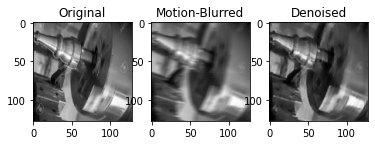

Image Restored in : 0.754979133605957 sec


In [ ]:
print('Input-Test image shape:', x.shape)
print('Restored-Test image shape:', denoised_img.shape)

f,ax = plt.subplots(1,3)
ax[0].set_title('Original')
ax[0].imshow(original, cmap = 'gray')
ax[1].set_title('Motion-Blurred')
ax[1].imshow(img, cmap = 'gray')
ax[2].set_title('Denoised')
ax[2].imshow(denoised_img, cmap = 'gray')
plt.show()

print('Image Restored in :', restore_time, 'sec')

In [ ]:
##Calc PSNR value

def PSNR (original, compressed):
    mse = np.mean((original-compressed) ** 2)
    if (mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20*log10(max_pixel/sqrt(mse))
    return psnr
img = cv2.imread('/content/drive/My Drive/dataset/all_JPG/download (59)_a_1.jpg', cv2.IMREAD_GRAYSCALE)
original = cv2.resize(img, img_size)
value1 = PSNR(original, sample_img)
value2 = PSNR(original, denoised_img)
print("PSNR value improved from: " + str(value2)+ "dB  to  " + str(value1)+ "dB")

PSNR value improved from: 6.526534812566162dB  to  27.973491002641925dB
